# Signal transformation

Notebook exploring wavelet transformation.

## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import peakutils # finding peaks
import pywt # wavelet transformation
from scipy import signal # signal processing

In [2]:
from dataclasses import dataclass

In [3]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [4]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [5]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Clip to last 90 minutes
    fhr = fhr.tail(90*60)

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    return(fhr)

In [6]:
# Clean all the traces
fhr_dict = {}
for key, value in csv_files.items():
    fhr_dict[key] = clean_fhr(value.FHR)

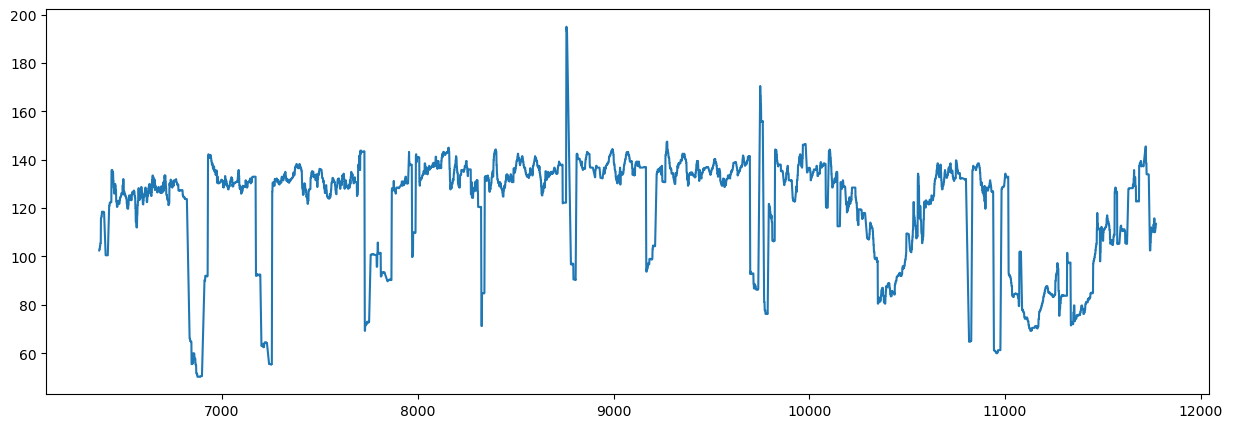

In [7]:
# Choose one
fhr = fhr_dict['1043']
fhr.plot(figsize=(15, 5))
plt.show()

Transformations using PyWavelets

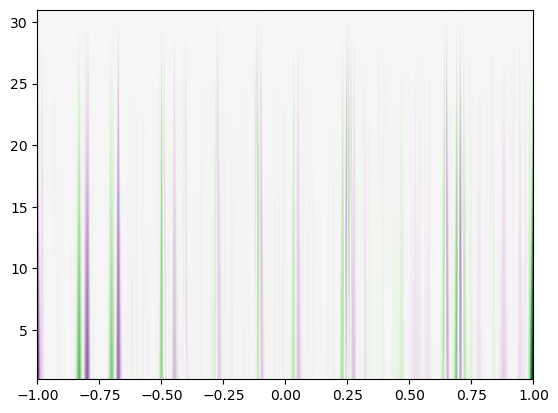

In [8]:
coef, freq = pywt.cwt(data=fhr, scales=np.arange(1, 31), wavelet='gaus1')

plt.imshow(
    coef,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coef).max(),
    vmin=-abs(coef).max(),
);

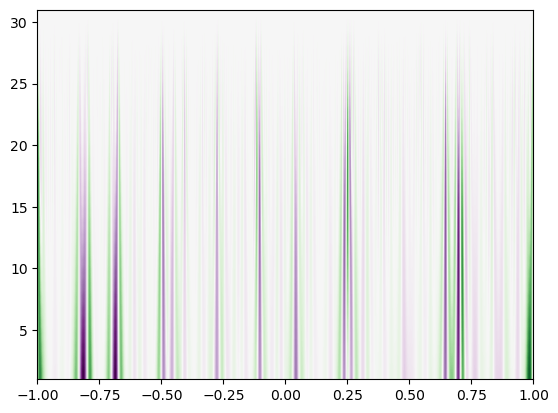

In [9]:
coef, freq = pywt.cwt(data=fhr, scales=np.arange(1, 31), wavelet='mexh')

plt.imshow(
    coef,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coef).max(),
    vmin=-abs(coef).max(),
);

Morelet wavelet

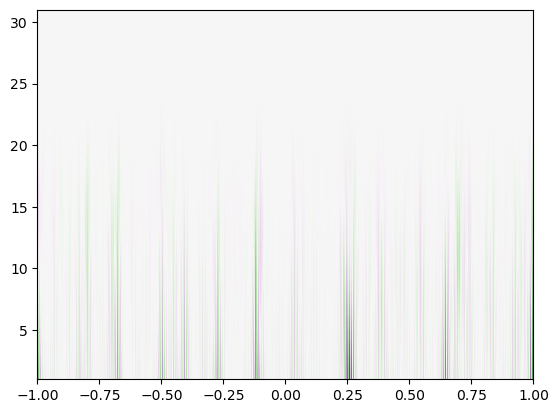

In [10]:
coef, freq = pywt.cwt(data=fhr, scales=np.arange(1, 31), wavelet='morl')

plt.imshow(
    coef,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coef).max(),
    vmin=-abs(coef).max(),
);

Complex morlet wavelet - cmorB-C where B is bandwidth and C is center frequency (not running as don't know values)

In [11]:
'''
coef, freq = pywt.cwt(data=fhr, scales=np.arange(1, 31), wavelet='cmorB-C')

plt.imshow(
    coef,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coef).max(),
    vmin=-abs(coef).max(),
);
'''

'\ncoef, freq = pywt.cwt(data=fhr, scales=np.arange(1, 31), wavelet=\'cmorB-C\')\n\nplt.imshow(\n    coef,\n    extent=[-1, 1, 1, 31],\n    cmap="PRGn",\n    aspect="auto",\n    vmax=abs(coef).max(),\n    vmin=-abs(coef).max(),\n);\n'

Transformation using SciPy

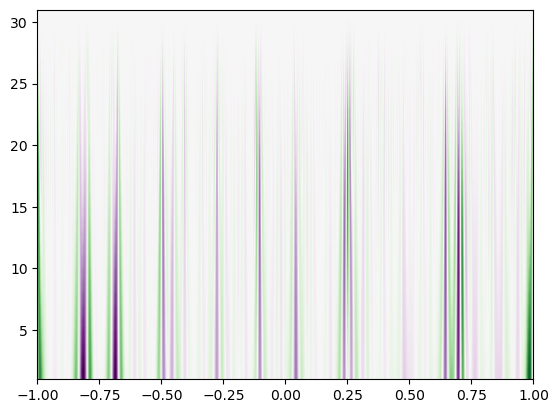

In [12]:
from scipy import signal
cwtmatr = signal.cwt(fhr, signal.ricker, np.arange(1, 31))

plt.imshow(
    cwtmatr,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(cwtmatr).max(),
    vmin=-abs(cwtmatr).max(),
);

In [13]:
# Define scales
scales = np.arange(1, 10)
# Get the normalised frequencies
norm = pywt.scale2frequency('morl', scales)
# Multiply those by your sampling frequency to get actual frequencies
norm*4
# It gives example where smallest frequency in decomposed signal is less than
# central frequency of signal so the decomposition may not be appropriate -
# but in this case, even the largest frequency in the decomposed signal (3.25)
# is larger than the central frequency of our signal (4)

array([3.25      , 1.625     , 1.08333333, 0.8125    , 0.65      ,
       0.54166667, 0.46428571, 0.40625   , 0.36111111])

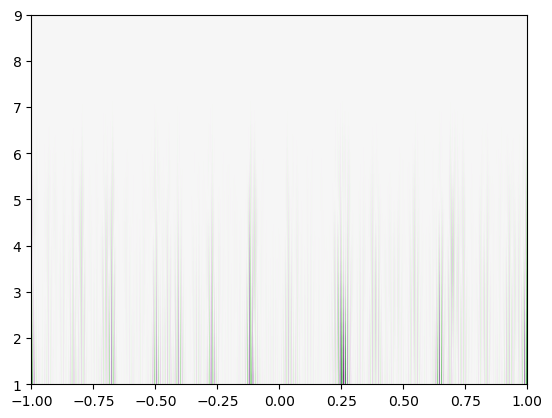

In [14]:
coeff, freq =  pywt.cwt(fhr, scales=scales, wavelet='morl')
plt.imshow(
    coef,
    extent=[-1, 1, np.min(scales), np.max(scales)],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coef).max(),
    vmin=-abs(coef).max(),
);

Taking real and imaginary components - https://www.kaggle.com/code/anjum48/continuous-wavelet-transform-cwt-in-pytorch

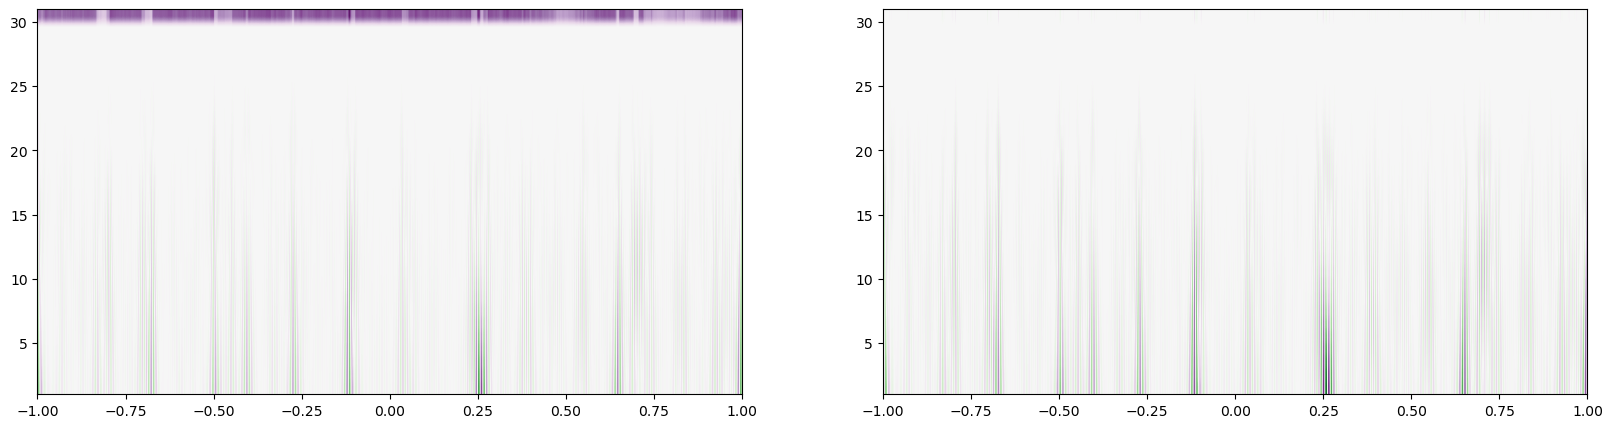

In [15]:
cwtmatr = signal.cwt(fhr, signal.morlet2, np.arange(1, 31))

real, imag = np.real(cwtmatr), np.imag(cwtmatr)

# Plot the real & imaginary components after CWT using a complex Morlet wavelet
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
axes[0].imshow(
    real,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(real).max(),
    vmin=-abs(real).max(),
)
axes[1].imshow(
    imag,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(imag).max(),
    vmin=-abs(imag).max(),
);

(30, 5400)


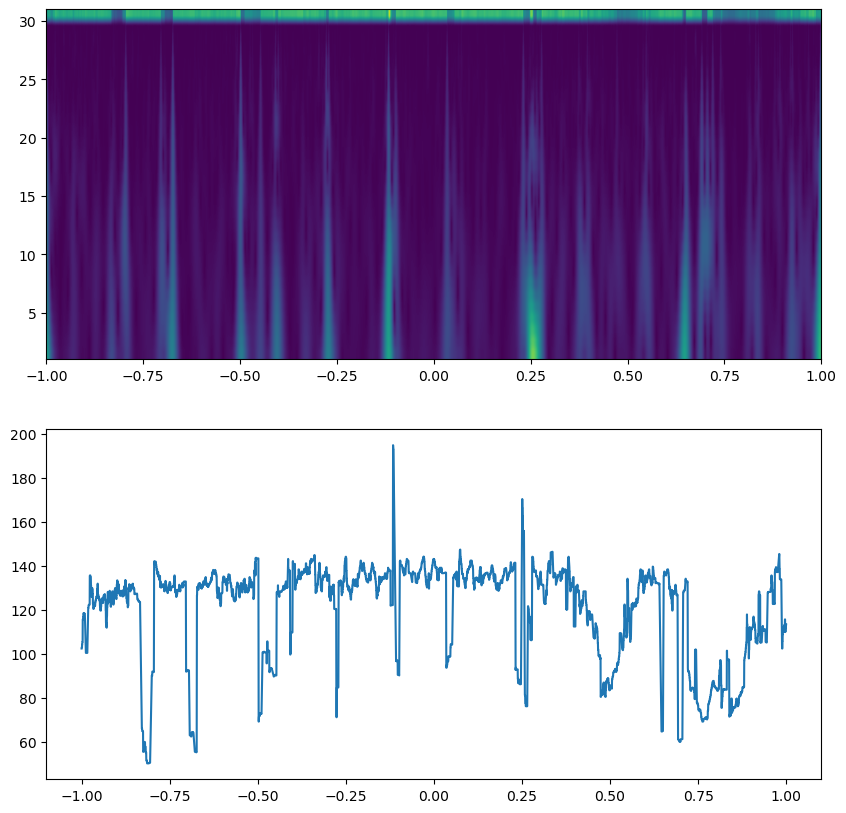

In [16]:
# Plot the magnitude with the raw signal
magn = np.absolute(cwtmatr)
print(magn.shape)
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
axes[0].imshow(
    magn,
    extent=[-1, 1, 1, 31],
    aspect="auto",
)
t = np.linspace(-1, 1, 5400, endpoint=False)
axes[1].plot(t, fhr);

Use db (Daubechies) and sym (symlets) mother wavelets with an order of 2, and three wavelet scales 4 5 6, in Zhao et al. 2019 - DeepFHR: intelligent prediction of fetal Acidemia using fetal heart rate signals based on convolutional neural network}

These both appear to be for DWT not CWT...

In [17]:
print(pywt.Wavelet('db2'))

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [18]:
print(pywt.Wavelet('sym2'))

Wavelet sym2
  Family name:    Symlets
  Short name:     sym
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False


In [19]:
print(pywt.ContinuousWavelet('gaus1'))

ContinuousWavelet gaus1
  Family name:    Gaussian
  Short name:     gaus
  Symmetry:       anti-symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


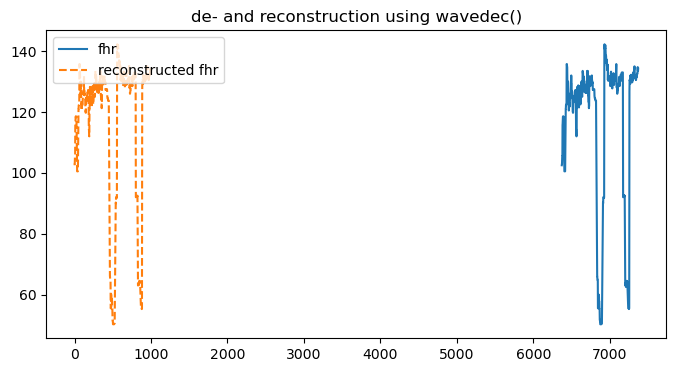

In [20]:
coeffs = pywt.wavedec(fhr, 'db2', level=8)
reconstructed_signal = pywt.waverec(coeffs, 'db2')
 
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(fhr[:1000], label='fhr')
ax.plot(reconstructed_signal[:1000], label='reconstructed fhr', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

Wavelet decomposition

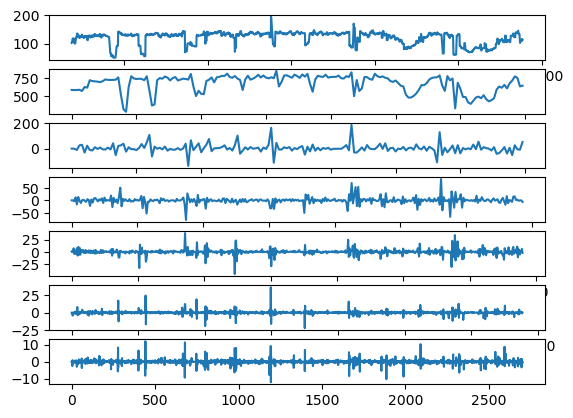

In [21]:
wavelets = pywt.wavedec(fhr,'db4', level=5)

fig, ax = plt.subplots(len(wavelets)+1)

ax[0].plot(fhr)

for i, wavelet in enumerate(wavelets):
   ax[i+1].plot(wavelet)

Recombining all the wavelets to get original signal

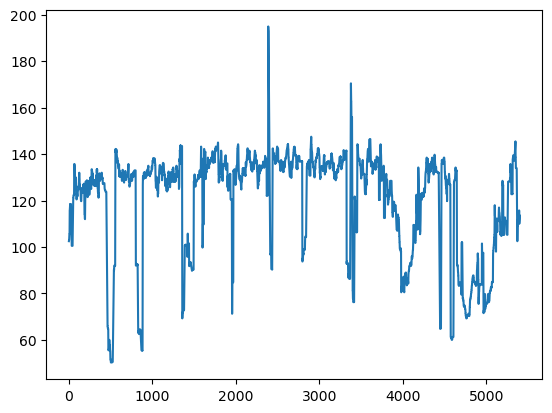

In [22]:
fig, ax = plt.subplots()
ax.plot(pywt.waverec(wavelets, 'db4'))

First wavelet often has like the major signal

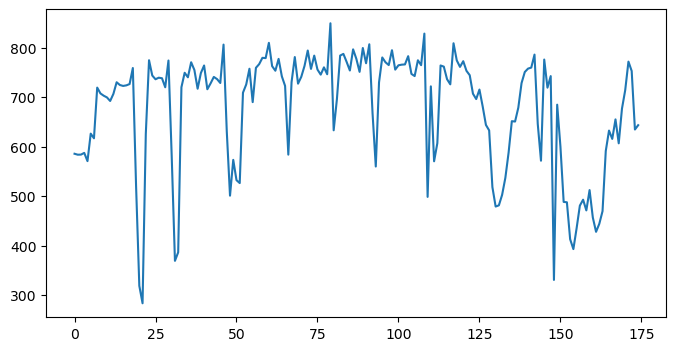

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(wavelets[0])

Can also recombine just a few wavelets - here its the first two

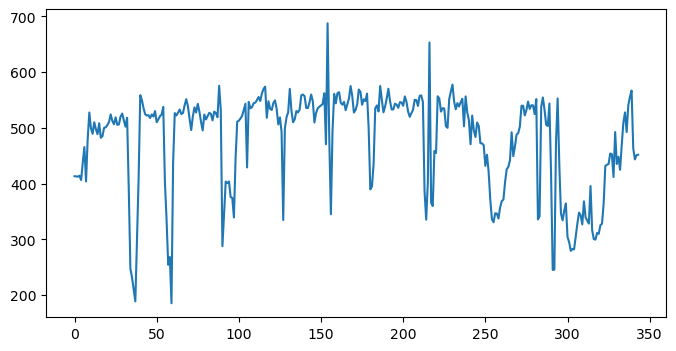

In [24]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(pywt.waverec(wavelets[0:2], 'db4'))

Find peaks (as they were trying to do that in an ECG tutorial, although here it's not necessarily peaks that are of interest)

* Finds the numeric index of the peaks in y by taking its first order difference. By using thres and min_dist parameters, it is possible to reduce the number of detected peaks. y must be signed.
* thres (float between [0., 1.]) – Normalized threshold. Only the peaks with amplitude higher than the threshold will be detected.
* min_dist (int) – Minimum distance between each detected peak. The peak with the highest amplitude is preferred to satisfy this constraint.

Don't think this is relevant for FHR.

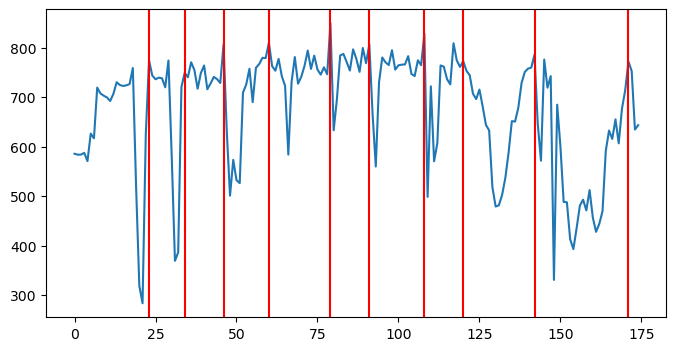

In [25]:
# Find peaks
peak_index = peakutils.indexes(wavelets[0], thres=0.8, min_dist=10)

# Set up figure
fig, ax = plt.subplots(figsize=(8,4))

# Plot the signal
ax.plot(wavelets[0])

# Add lines for each peak
for peak in peak_index:
    ax.axvline(x=peak, color='r')